In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, LogisticRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay, fbeta_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('weatherHistory.csv', skiprows=range(1, 2000), nrows=3000)
mushrooms = pd.read_csv('mushrooms.csv')

In [3]:
#Weather dataset
df = df.drop(['Formatted Date', 'Summary', 'Precip Type', 'Loud Cover'], axis=1)
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

label_enc = LabelEncoder()
ordinal_columns = df.select_dtypes('object').columns
for column in ordinal_columns:
    df[column] = label_enc.fit_transform(df[column])

normalized_values = StandardScaler().fit_transform(df)
df = pd.DataFrame(normalized_values, columns=df.columns)

#Mushrooms dataset
mushrooms = mushrooms.drop(['veil-type', 'stalk-root'], axis=1)
mushrooms.fillna(mushrooms.mean(numeric_only=True), inplace=True)
mushrooms.fillna(mushrooms.mode().iloc[0], inplace=True)

ordinal_columns = mushrooms.select_dtypes('object').columns
for column in ordinal_columns:
    mushrooms[column] = label_enc.fit_transform(mushrooms[column])

In [4]:
vif_data = pd.DataFrame()
vif_data["Feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df, i) for i in range(df.shape[1])]

print(vif_data)

                    Feature         VIF
0           Temperature (C)  156.336081
1  Apparent Temperature (C)  156.526349
2                  Humidity    1.639953
3         Wind Speed (km/h)    1.814783
4    Wind Bearing (degrees)    1.028329
5           Visibility (km)    1.386157
6      Pressure (millibars)    1.029321
7             Daily Summary    1.541776


In [5]:
#Weather dataset
Y = pd.DataFrame(df['Apparent Temperature (C)'].values)
X = df.loc[:, df.columns != 'Apparent Temperature (C)'].values

X_single = pd.DataFrame(df['Humidity'])
X_half = df.loc[:, ['Humidity', 'Visibility (km)', 'Daily Summary']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

single_train, single_test, half_train, half_test = train_test_split(X_single, X_half, test_size = 0.3, random_state = 42)

#Mushrooms dataset
Y_mushrooms = mushrooms['class'].values
X_mushrooms = mushrooms.loc[:, mushrooms.columns != 'class'].values

normalized_values = StandardScaler().fit_transform(X_mushrooms)
X_mushrooms = pd.DataFrame(normalized_values, columns=mushrooms.columns[0:20])

X_mushrooms_train, X_mushrooms_test, Y_mushrooms_train, Y_mushrooms_test = train_test_split(X_mushrooms, Y_mushrooms, test_size = 0.3, random_state = 42)

In [6]:
single_X = Ridge(alpha = 1.0)
single_X.fit(single_train, Y_train)
single_X_predict = single_X.predict(single_test)

half_X = Ridge(alpha = 10)
half_X.fit(half_train, Y_train)
half_X_predict = half_X.predict(half_test)

ridge = Ridge(alpha = 1e-10)
ridge.fit(X_train, Y_train)
ridge_predict = ridge.predict(X_test)

In [7]:
def adj_r2(regressor, X_test, Y_test):
    adj_r2 = 1 - (1 - regressor.score(X_test, Y_test)) * ((Y_test.shape[0] - 1)/(Y_test.shape[0] - X_test.shape[1] - 1))
    return adj_r2

regression_scores = pd.DataFrame()

regression_scores['Model'] = ['Ridge for single X', 'Ridge for half Xs', 'Ridge for multiple Xs']

regression_scores['R2'] = [single_X.score(single_test, Y_test), half_X.score(half_test, Y_test), ridge.score(X_test, Y_test)]
regression_scores['Adj_R2'] = [adj_r2(single_X, single_test, Y_test), adj_r2(half_X, half_test, Y_test), adj_r2(ridge, X_test, Y_test)]

regression_scores['MAE'] = [mean_absolute_error(Y_test, single_X_predict), mean_absolute_error(Y_test, half_X_predict), mean_absolute_error(Y_test, ridge_predict)]
regression_scores['MSE'] = [mean_squared_error(Y_test, single_X_predict), mean_squared_error(Y_test, half_X_predict), mean_squared_error(Y_test, ridge_predict)]

regression_scores['RMSE'] = [root_mean_squared_error(Y_test, single_X_predict), root_mean_squared_error(Y_test, half_X_predict), root_mean_squared_error(Y_test, ridge_predict)]

regression_scores

,Model,R2,Adj_R2,MAE,MSE,RMSE
0,Ridge for single X,0.313117,0.312353,0.686956,0.678342,0.823615
1,Ridge for half Xs,0.407315,0.405331,0.604866,0.585315,0.765059
2,Ridge for multiple Xs,0.993004,0.992950,0.066226,0.006909,0.083118


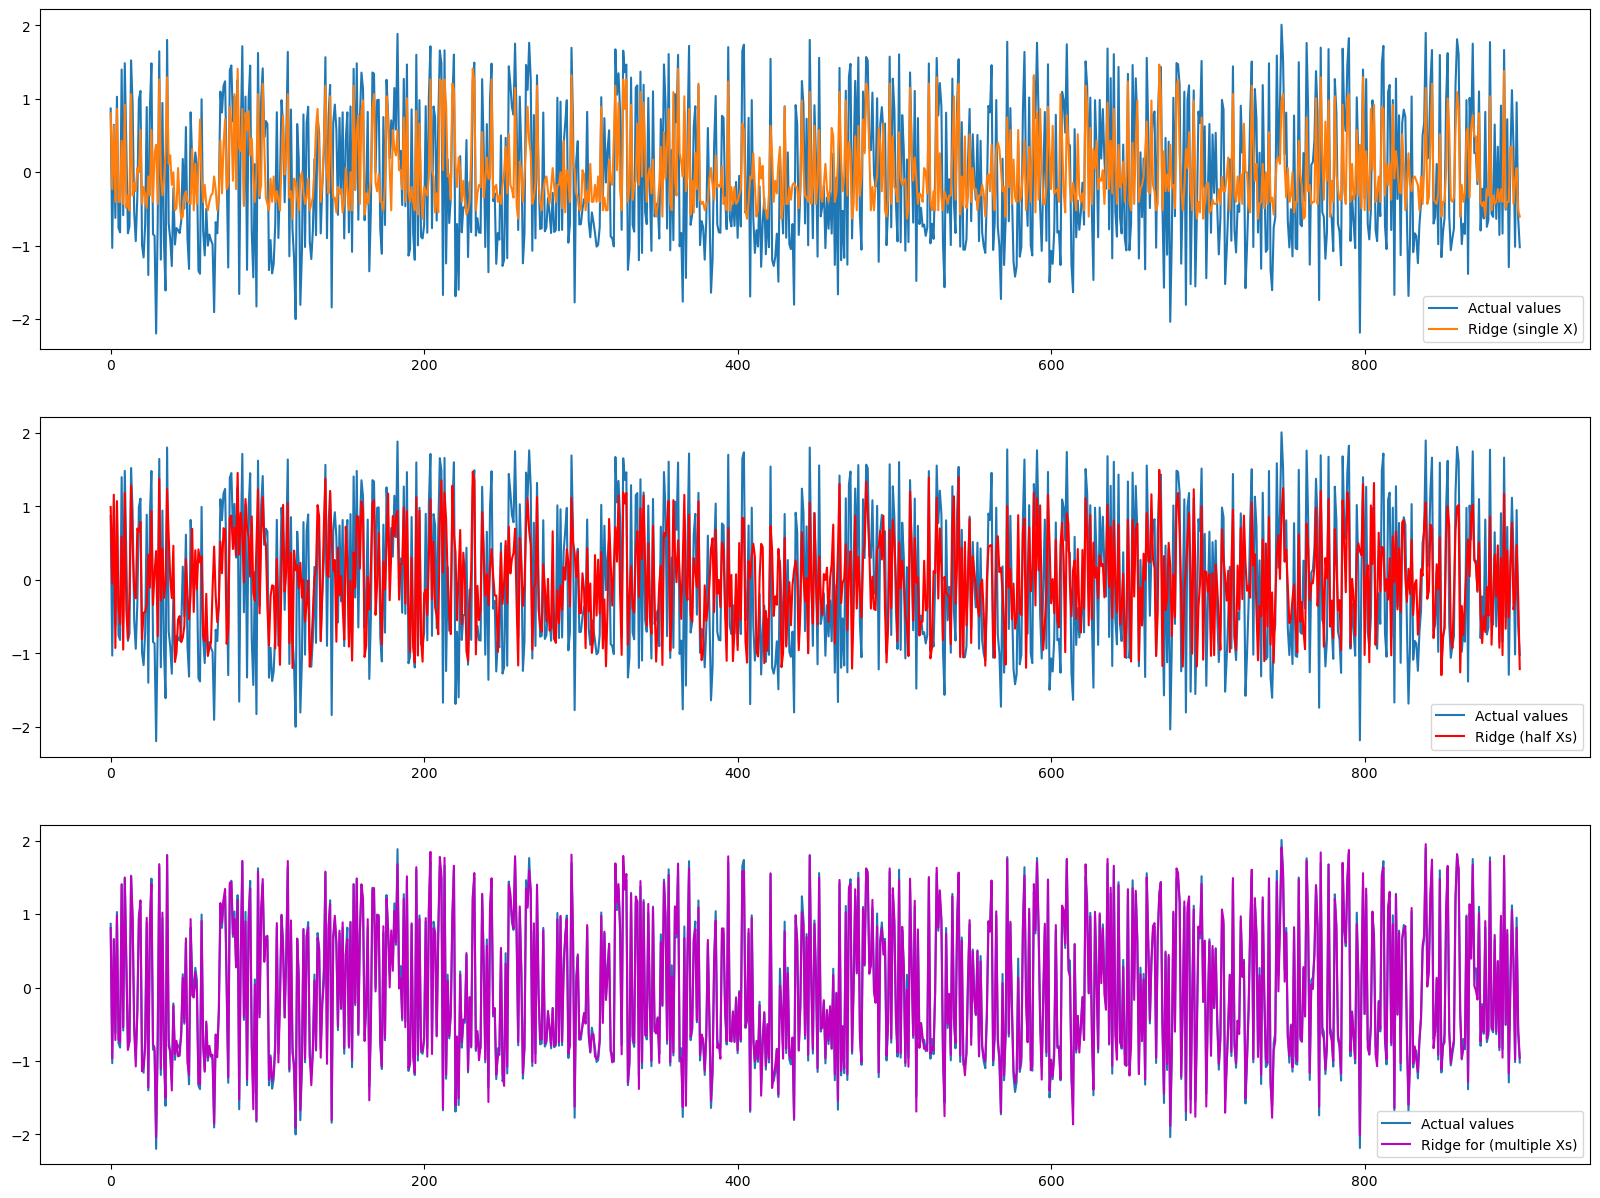

In [8]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(20, 15))

ax1.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax1.plot([i for i in range(len(Y_test))], single_X_predict, label="Ridge (single X)")
ax1.legend()

ax2.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax2.plot([i for i in range(len(Y_test))], half_X_predict, c='r', label="Ridge (half Xs)")
ax2.legend()

ax3.plot([i for i in range(len(Y_test))], Y_test, label="Actual values")
ax3.plot([i for i in range(len(Y_test))], ridge_predict, c='m', label="Ridge for (multiple Xs)")
ax3.legend()

plt.show()

In [9]:
log_regress = LogisticRegression(solver='newton-cg')
log_regress.fit(X_mushrooms_train, Y_mushrooms_train)
log_regress_predict = log_regress.predict(X_mushrooms_test)

#optimal param: criterion='gini', max_depth=7, min_samples_leaf=3, min_samples_split=2
desicion_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=5)
desicion_tree.fit(X_mushrooms_train, Y_mushrooms_train)
desicion_tree_predict = desicion_tree.predict(X_mushrooms_test)

#optimal param: criterion='gini', max_depth=8, min_samples_leaf=3, min_samples_split=6
random_forest = RandomForestClassifier(criterion='gini', max_depth=3, min_samples_leaf=5)
random_forest.fit(X_mushrooms_train, Y_mushrooms_train)
random_forest_predict = random_forest.predict(X_mushrooms_test)

In [10]:
classifiers_scores = pd.DataFrame()

classifiers_scores['Model'] = ['Logistic Regression', 'Decision Tree', 'Random Forest']

classifiers_scores['Accuracy score'] = [accuracy_score(log_regress_predict, Y_mushrooms_test), accuracy_score(desicion_tree_predict, Y_mushrooms_test), 
                                    accuracy_score(random_forest_predict, Y_mushrooms_test)]
classifiers_scores['Precision score'] = [precision_score(log_regress_predict, Y_mushrooms_test), precision_score(desicion_tree_predict, Y_mushrooms_test), 
                                    precision_score(random_forest_predict, Y_mushrooms_test)]
classifiers_scores['Recall score'] = [recall_score(log_regress_predict, Y_mushrooms_test), recall_score(desicion_tree_predict, Y_mushrooms_test), 
                                    recall_score(random_forest_predict, Y_mushrooms_test)]
classifiers_scores['F1 score'] = [f1_score(log_regress_predict, Y_mushrooms_test), f1_score(desicion_tree_predict, Y_mushrooms_test), 
                                    f1_score(random_forest_predict, Y_mushrooms_test)]

classifiers_scores['F-beta 0.5 score'] = [fbeta_score(Y_mushrooms_test, log_regress_predict, beta=0.5), fbeta_score(Y_mushrooms_test, desicion_tree_predict, beta=0.5), 
                                    fbeta_score(Y_mushrooms_test, random_forest_predict, beta=0.5)]
classifiers_scores['F-beta 1 score'] = [fbeta_score(Y_mushrooms_test, log_regress_predict, beta=1), fbeta_score(Y_mushrooms_test, desicion_tree_predict, beta=1), 
                                    fbeta_score(Y_mushrooms_test, random_forest_predict, beta=1)]
classifiers_scores['F-beta 2 score'] = [fbeta_score(Y_mushrooms_test, log_regress_predict, beta=2), fbeta_score(Y_mushrooms_test, desicion_tree_predict, beta=2), 
                                    fbeta_score(Y_mushrooms_test, random_forest_predict, beta=2)]

classifiers_scores['ROC AUC score'] = [roc_auc_score(Y_mushrooms_test, log_regress_predict), roc_auc_score(Y_mushrooms_test, desicion_tree_predict), 
                                    roc_auc_score(Y_mushrooms_test, random_forest_predict)]

classifiers_scores

,Model,Accuracy score,Precision score,Recall score,F1 score,F-beta 0.5 score,F-beta 1 score,F-beta 2 score,ROC AUC score
0,Logistic Regression,0.946678,0.939035,0.950300,0.944634,0.948025,0.944634,0.941266,0.946447
1,Decision Tree,0.952420,0.976291,0.929089,0.952106,0.938161,0.952106,0.966471,0.953142
2,Random Forest,0.983183,0.974598,0.990534,0.982501,0.987305,0.982501,0.977744,0.982923


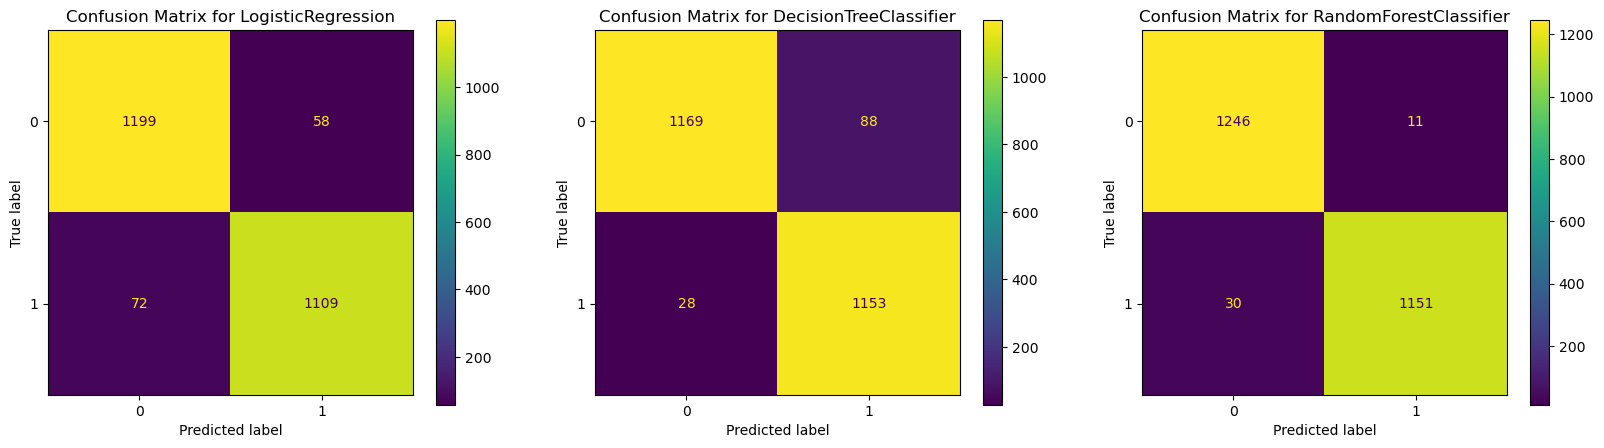

In [11]:
classifiers = [log_regress, desicion_tree, random_forest]

fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, clf in zip(axs, classifiers):
    disp = ConfusionMatrixDisplay.from_estimator(clf, X_mushrooms_test, Y_mushrooms_test, ax=ax)
    ax.set_title( f"Confusion Matrix for {clf.__class__.__name__}")
plt.show()

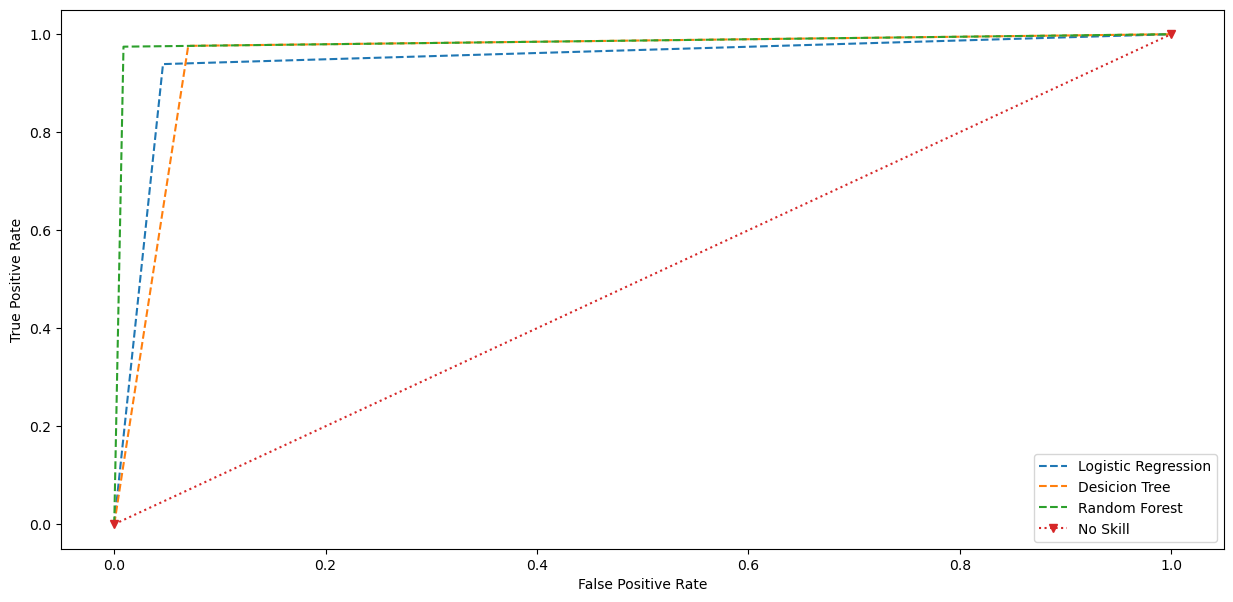

In [12]:
predicts = [log_regress_predict, desicion_tree_predict, random_forest_predict]
names = ['Logistic Regression', 'Desicion Tree', 'Random Forest']
random_probs = [0 for i in range(len(Y_mushrooms_test))]
p_fpr, p_tpr, _ = roc_curve(Y_mushrooms_test, random_probs, pos_label=1)

fig = plt.subplots(figsize=(15, 7))
for pred, name in zip(predicts, names):
    fpr, tpr, _ = roc_curve(Y_mushrooms_test, pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'{name}')

plt.plot(p_fpr, p_tpr, marker='v', linestyle=':', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()